# Stochastic Variational Inference with Parametric Priors
This script provides an implementation of stochastic variational inference with parametric priors. Here, we use the very same setup as in svicnn.ipynb except for some modifications specific to paraemtric prior distributions.

## Import some necessary packages

In [1]:
import tqdm
import torch
import numpy as np
import torch.nn as nn

from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from util.dataset import make_mnist
from model.vicnn import VICNN, ELBO
from model.cnn import CNN
from torch.optim import Adam
from torch.utils.data import DataLoader
from util.util import show_images, run_model_on_data

## Building a variational CNN
We use the exact same setup as in svicnn.ipynb. Therefore, we skip the introduction into the Bayesian design and maths here and focus on only the new stuff.

### Introducing a parametric prior
As opposed to the design presented in svicnn.ipynb, where we had a fixed prior distribution over our network weights and biases, here we introduce a learnable parametric distribution. Once again, we choose a Gaussian one, where the learnable parameters are $\mu_\xi$ and $\sigma_\xi$.

That is
$$
p_\xi(z) = \mathcal{N}(\mu_\xi,\sigma_\xi) = \frac{1}{\sigma_\xi\sqrt{2\pi}} \exp\left( -\frac{(z - \mu_\xi)^2}{2\sigma_\xi^2} \right)
$$


The code below for the network design is just slightly modified to accomodate for these new parameters. For convenience, we make them members of the network layer classes. Although they will only be used inside the ELBO loss function later.

In [2]:
class MeanFieldGaussianLinear(nn.Module):
	def __init__(self, 
			  in_features, 
			  out_features, 
			  init_sigma_w=1e-7,
			  init_sigma_b=5e-7,
			  init_prior_sigma_w=1.0,
			  init_prior_sigma_b=5.0):
		super(MeanFieldGaussianLinear, self).__init__()

		# Weights for p_xi(z)
		self.prior_mean_w = Parameter(torch.rand(out_features, in_features) - 0.5)
		self.prior_sigma_w = Parameter(torch.log(init_prior_sigma_w * torch.ones(out_features, in_features)))
		
		# Bias for p_xi(z)
		self.prior_mean_b = Parameter(torch.rand(out_features) - 0.5)
		self.prior_sigma_b = Parameter(torch.log(init_prior_sigma_b * torch.ones(out_features)))
		
		# Weights for q(z)
		self.mean_w = Parameter(torch.rand(out_features, in_features) - 0.5)
		self.sigma_w = Parameter(torch.log(init_sigma_w * torch.ones(out_features, in_features)))
		self.normal_w = Normal(torch.zeros(out_features, in_features), torch.ones(out_features, in_features))
		
		# Bias for q(z)
		self.mean_b = Parameter(torch.rand(out_features) - 0.5)
		self.sigma_b = Parameter(torch.log(init_sigma_b * torch.ones(out_features)))
		self.normal_b = Normal(torch.zeros(out_features), torch.ones(out_features))
		
	def forward(self, x):
		# Sample weights
		epsilon_w = self.normal_w.sample().to(device=self.mean_w.device)
		self.z_w = self.mean_w + torch.exp(self.sigma_w) * epsilon_w
		
		# Sample bias
		epsilon_b = self.normal_b.sample().to(device=self.mean_b.device)
		self.z_b = self.mean_b + torch.exp(self.sigma_b) * epsilon_b

		return nn.functional.linear(x, self.z_w, bias=self.z_b)
	
	
class MeanFieldGaussianConv2d(nn.Module):
	def __init__(self,
			  in_channels, 
			  out_channels, 
			  kernel_size, 
			  init_sigma_w=1e-7, 
			  init_sigma_b=5e-7,
			  init_prior_sigma_w=1.0, 
			  init_prior_sigma_b=5.0,):
		super(MeanFieldGaussianConv2d, self).__init__()

		# Weights for p_xi(z)
		self.prior_mean_w = Parameter(torch.rand(out_channels, in_channels, kernel_size, kernel_size) - 0.5)
		self.prior_sigma_w = Parameter(torch.log(init_prior_sigma_w * torch.ones(out_channels, in_channels, kernel_size, kernel_size)))
		
		# Bias for p_xi(z)
		self.prior_mean_b = Parameter(torch.rand(out_channels) - 0.5)
		self.prior_sigma_b = Parameter(torch.log(init_prior_sigma_b * torch.ones(out_channels)))

		# Weights for q(z)
		self.mean_w = Parameter(torch.rand(out_channels, in_channels, kernel_size, kernel_size) - 0.5)
		self.sigma_w = Parameter(torch.log(init_sigma_w * torch.ones(out_channels, in_channels, kernel_size, kernel_size)))
		self.normal_w = Normal(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), 
								   torch.ones(out_channels, in_channels, kernel_size, kernel_size))
		
		# Bias for q(z)
		self.mean_b = Parameter(torch.rand(out_channels) - 0.5)
		self.sigma_b = Parameter(torch.log(init_sigma_b * torch.ones(out_channels)))
		self.normal_b = Normal(torch.zeros(out_channels), torch.ones(out_channels))
			
	def forward(self, x):
		# Sample weights
		epsilon_w = self.normal_w.sample().to(device=self.mean_w.device)
		self.z_w = self.mean_w + torch.exp(self.sigma_w) * epsilon_w
		
		# Sample bias
		epsilon_b = self.normal_b.sample().to(device=self.mean_b.device)
		self.z_b = self.mean_b + torch.exp(self.sigma_b) * epsilon_b
		
		return nn.functional.conv2d(x, self.z_w, bias=self.z_b)


class VICNN(nn.Module):
	def __init__(self, init_sigma_w=1e-7, init_sigma_b=5e-7, init_prior_sigma_w=1.0, init_prior_sigma_b=5.0):
		super().__init__()
		
		self.conv1 = MeanFieldGaussianConv2d(1, 16, kernel_size=5,
											 init_sigma_w=init_sigma_w, 
											 init_sigma_b=init_sigma_b,
											 init_prior_sigma_w=init_prior_sigma_w,
											 init_prior_sigma_b=init_prior_sigma_b)
		self.conv2 = MeanFieldGaussianConv2d(16, 32, kernel_size=5,
											 init_sigma_w=init_sigma_w, 
											 init_sigma_b=init_sigma_b,
											 init_prior_sigma_w=init_prior_sigma_w,
											 init_prior_sigma_b=init_prior_sigma_b)
		self.linear1 = MeanFieldGaussianLinear(512, 128,
											 init_sigma_w=init_sigma_w, 
											 init_sigma_b=init_sigma_b,
											 init_prior_sigma_w=init_prior_sigma_w,
											 init_prior_sigma_b=init_prior_sigma_b)
		self.linear2 = MeanFieldGaussianLinear(128, 10,
											 init_sigma_w=init_sigma_w, 
											 init_sigma_b=init_sigma_b,
											 init_prior_sigma_w=init_prior_sigma_w,
											 init_prior_sigma_b=init_prior_sigma_b)

	def forward(self, x):
		x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
		x = self.conv2(x)
		
		x = nn.functional.relu(nn.functional.max_pool2d(x, 2))
		x = x.view(-1, 512)
		x = nn.functional.relu(self.linear1(x))
		
		x = self.linear2(x)
		return nn.functional.log_softmax(x, dim=-1)

## Derivation and implementation of the ELBO
The derivation of the ELBO does not change from the previous setting. Thus, we will skip this. The only difference is the final ELBO equation which now shows our new parametric prior instead of the previously fixed one.

$$
\begin{align*}
ELBO(q) &= \mathop{\mathbb{E}}_q\log p(D|z) + \mathop{\mathbb{E}}_q\log p_\xi(z) - \mathop{\mathbb{E}}_q\log q(z)
\end{align*}
$$

## Putting the loss together
The only difference in the loss function is then a $\mathcal{L}_{p_\xi}$ term, which is now parametric and needs to be optimized. Inserting our chosen prior distribution in the ELBO and simplifying yields the following.
$$
\begin{align*}
\mathcal{L} &= \mathcal{L}_{p_\xi} + \mathcal{L}_q + \mathcal{L}_D \\
\mathcal{L}_{p_\xi} &= -\log \left(\frac{1}{\sigma_\xi\sqrt{2\pi}} \exp\left( -\frac{(z - \mu_\xi)^2}{2\sigma_\xi^2} \right) \right) \\
&= -\log 1 + \log \left(\sigma_\xi\sqrt{2\pi}\right) - \log \exp\left( -\frac{(z - \mu_\xi)^2}{2\sigma_\xi^2} \right) \\
&= \log \sigma_\xi + \frac{\log (2\pi)}{2} + \frac{(z - \mu_\xi)^2}{2\sigma_\xi^2} \\
\end{align*}
$$

After removing all constants from these loss terms, we thus finally have
$$
\begin{align*}
\mathcal{L} &= \mathcal{L}_{p_\xi} + \mathcal{L}_q + \mathcal{L}_D \\
&= \log \sigma_\xi + \frac{(z - \mu_\xi)^2}{2\sigma_\xi^2} - \log \sigma - \log p(D_y|D_x, z) \\
\end{align*}
$$

In [3]:
class ELBO():
	def __init__(self, variational_modules, dataset_size):
		self.variational_modules = variational_modules
		self.loss_D = torch.nn.NLLLoss(reduction='mean')
		self.dataset_size = dataset_size

	def loss_p(self, z, mean_p, sigma_p):
		return sigma_p.sum() + 0.5 * ((z - mean_p).pow(2) / torch.exp(sigma_p).pow(2)).sum()
		
	def loss_q(self, sigma):
		return -sigma.sum()
		
	def __call__(self, pred, labels):
		loss = 0
		for module in self.variational_modules:
			# Weights loss
			loss += self.loss_p(module.z_w, module.prior_mean_w, module.prior_sigma_w)
			loss += self.loss_q(module.sigma_w)

			# Bias loss
			loss += self.loss_p(module.z_b, module.prior_mean_b, module.prior_sigma_b)
			loss += self.loss_q(module.sigma_b)
			
		# Negative loss likelihood
		loss += self.dataset_size * self.loss_D(pred, labels)
		return loss

## Train a frequentist CNN on some data
A BNN with parametric priors becomes only really interesting when we have at least some prior knowledge and want to learn only a subset of these priors. To simulate this we first train a "normal" CNN on some data in a simple frequentist setting. We then transfer some of the trained weights over to our actual Bayesian network.

In [4]:
# Training settings
epochs = 10
lr = 5e-3
filtered_class = 5
batch_size = 64
train, test = make_mnist(filteredClass=filtered_class)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

# Initialize the model and set up ELBO as the loss function
frequentist_model = CNN()
loss_fn = torch.nn.NLLLoss()
optimizer = Adam(frequentist_model.parameters(), lr=lr)
optimizer.zero_grad()

# Start the training loop
for epoch in np.arange(epochs):
    for images, labels in (pbar := tqdm.tqdm(train_loader, total=len(train) // batch_size)):
        pred = frequentist_model(images)
        loss = loss_fn(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"E={epoch} L={loss.detach():0.6f}")

E=0 L=0.026914: : 853it [00:08, 104.85it/s]                       
E=1 L=0.039203: : 853it [00:08, 104.54it/s]                       
E=2 L=0.100150: : 853it [00:08, 105.53it/s]                       
E=3 L=0.052522: : 853it [00:08, 103.36it/s]                       
E=4 L=0.000585: : 853it [00:08, 106.41it/s]                       
E=5 L=0.036380: : 853it [00:08, 104.45it/s]                       
E=6 L=0.077820: : 853it [00:08, 105.15it/s]                       
E=7 L=0.036224: : 853it [00:08, 104.32it/s]                       
E=8 L=0.017345: : 853it [00:08, 103.46it/s]                       
E=9 L=0.117793: : 853it [00:08, 105.07it/s]                       


## Train the model on MNIST
Now, let's replace the $\mu_\xi$ of our two convolutional layers with the trained parameters from the frequentists model. We also lower the respective $\sigma_\xi$ somewhat. By doing so, we essentially tell the network to stay in that area, because we already expect this to be a good place.

Let's now train our variational model on the MNIST dataset. To show off some special feature of Bayesian Networks, we exclude a class from the train dataset and see later how the model reacts to it.


In [5]:
# Training settings
epochs = 10
lr = 5e-3
lr_xi = 5e-4
filtered_class = 5
batch_size = 64
train, test = make_mnist(filteredClass=filtered_class)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

# Instantiate the variational model and use some learned parameters of the trained frequentist CNN as prior means
model = VICNN()
model_means = [model.conv1.prior_mean_w, model.conv1.prior_mean_b, model.conv2.prior_mean_w, model.conv2.prior_mean_b]
frequentist_means = [model.conv1.prior_mean_w, model.conv1.prior_mean_b, model.conv2.prior_mean_w, model.conv2.prior_mean_b]

# Remove them form the optimization
for model_mean, frequentist_mean in zip(model_means, frequentist_means):
    model_mean = frequentist_mean
    model_mean.requires_grad = False

# Also reduce their respective variances as we want the model to stay closer to the prior now
model_sigmas = [model.conv1.prior_sigma_w, model.conv1.prior_sigma_b, model.conv2.prior_sigma_w, model.conv2.prior_sigma_b]
with torch.no_grad():
    for sigma in model_sigmas:
        sigma.data += torch.log(torch.tensor(0.01))

# Initialize the model and set up ELBO as the loss function
elbo = ELBO([m for m in model.children() if hasattr(m, "mean_w")], len(train))

# Use independent optimizers for prior and q parameters
params = list(model.named_parameters())
optimizer = Adam([p[1] for p in params if "prior" not in p[0]], lr=lr)
optimizer_xi = Adam([p[1] for p in params if "prior" in p[0]], lr=lr_xi)
optimizer.zero_grad()
optimizer_xi.zero_grad()

# Start the training loop
for epoch in np.arange(epochs):
    for images, labels in (pbar := tqdm.tqdm(train_loader, total=len(train) // batch_size)):
        pred = model(images)
        loss = elbo(pred, labels)
        optimizer.zero_grad()
        optimizer_xi.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer_xi.step()
        pbar.set_description(f"E={epoch} L={loss.detach():0.2f}")

E=0 L=1014039.69: : 853it [00:10, 80.31it/s]                       
E=1 L=517738.62: : 853it [00:10, 78.74it/s]                       
E=2 L=176758.11: : 853it [00:10, 77.84it/s]                       
E=3 L=62695.83: : 853it [00:10, 78.88it/s]                        
E=4 L=66661.69: : 853it [00:10, 79.79it/s]                       
E=5 L=46614.75: : 853it [00:10, 78.10it/s]                       
E=6 L=59705.15: : 853it [00:10, 79.04it/s]                       
E=7 L=59297.55: : 853it [00:10, 77.69it/s]                       
E=8 L=48637.55: : 853it [00:10, 78.89it/s]                       
E=9 L=44813.83: : 853it [00:11, 77.03it/s]                       


## Visualize results
Let's run the network on some test data samples and see what predictive distributions it produces.

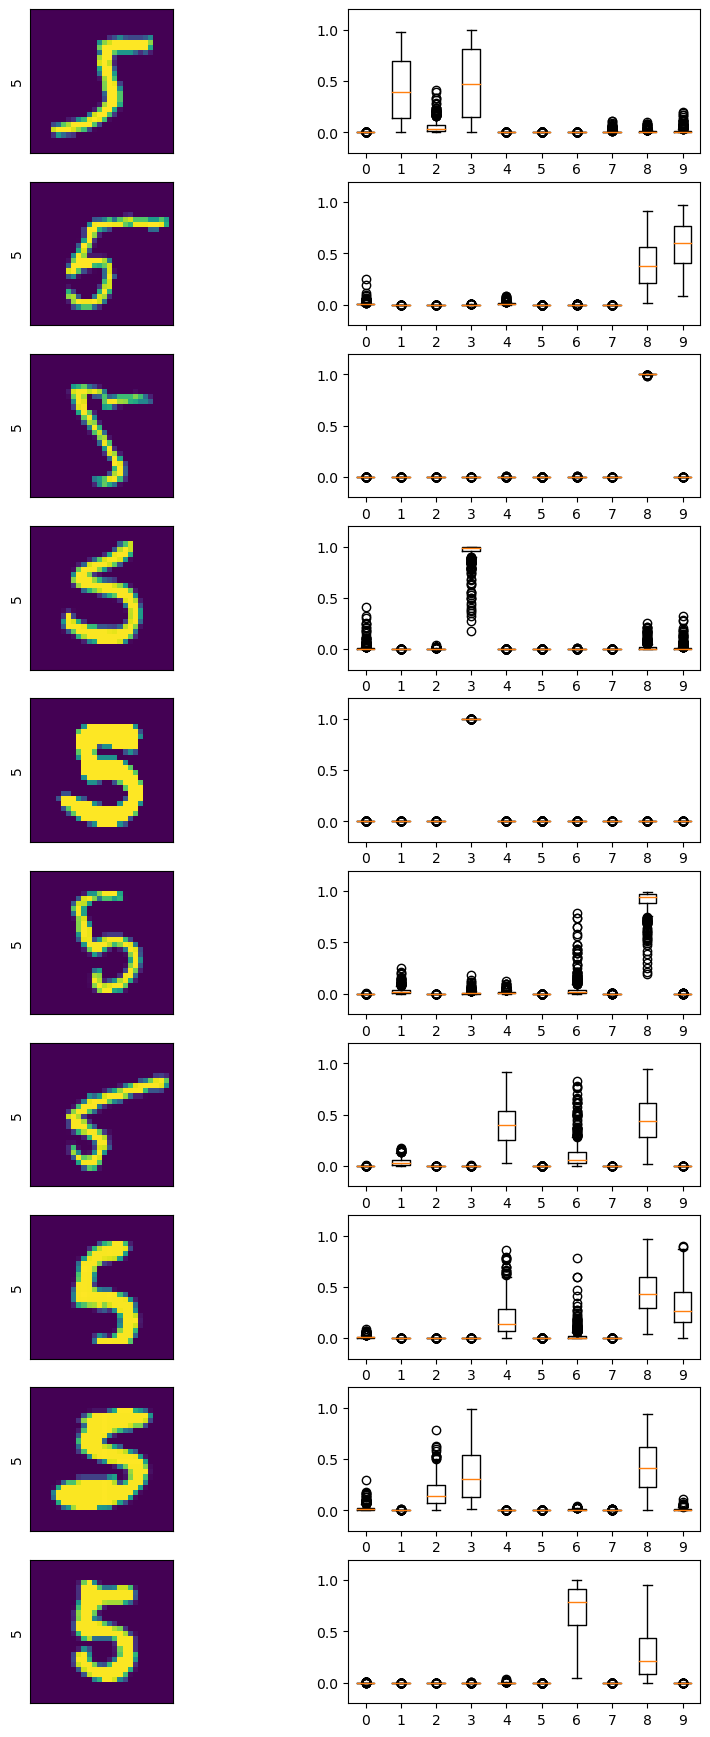

In [6]:
# Pick n test images and sample each num_samples times
# To select only a certain class, assign filter_class the corresponding number
num_images = 10
num_samples_per_image = 512
select_class = 5

_, test = make_mnist()
images, labels, samples = run_model_on_data(model, test, num_images, num_samples_per_image, select_class)

# Show input images alongside Whisker plots
show_images(images, samples, labels)